In [8]:
!pip3 uninstall evo -y
!python3 -m pip install -e /home/joshuabird/Documents/multi-agent-evo

Found existing installation: evo 1.26.1
Uninstalling evo-1.26.1:
  Successfully uninstalled evo-1.26.1
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/joshuabird/Documents/multi-agent-evo
  Preparing metadata (setup.py) ... done
  Running setup.py develop for evo

[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [15]:
from evo.tools import log
log.configure_logging()
from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation
from evo.core.units import Unit
from evo.tools.settings import SETTINGS

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

# interactive widgets configuration
import ipywidgets

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

agent_ids = [1,2]

In [16]:
from evo.tools import file_interface
from rosbags.rosbag2 import Reader as Rosbag2Reader
from rosbags.serde import deserialize_cdr
import math
import numpy as np
from scipy.spatial.transform import Rotation
from pathlib import Path
import os
from rosbags.typesys import get_types_from_idl, get_types_from_msg, register_types
import copy

# Add custom types
interfaces_dir = "../interfaces/msg/"
for file in os.listdir(interfaces_dir):
    msg_text = Path(interfaces_dir + file).read_text()
    register_types(get_types_from_msg(msg_text, "interfaces/msg/"+file[:-4]))


traj_ests = {}
traj_refs = {}
with Rosbag2Reader("/home/joshuabird/Desktop/send-new-keyframes-trajectory") as reader:
    # Read the trajectory and ground truth for each agent
    for agent_id in agent_ids:
        traj_est = file_interface.read_bag_trajectory(reader, f"/robot{agent_id}/camera_pose", transform_to_root_tf_frame_id="/world", use_final_tf_state=True)
        traj_ref = file_interface.read_bag_trajectory(reader, f"/robot{agent_id}/ground_truth_pose")

        traj_ests[agent_id] = traj_est
        traj_refs[agent_id] = traj_ref

    # # Find split points where a trajectory had to change its frame of reference
    # split_points = {}
    # for agent_id in agent_ids:
    #     for connection, _, rawdata in reader.messages():
    #         if connection.topic == f'/robot{agent_id}/successfully_merged':
    #             msg = deserialize_cdr(rawdata, connection.msgtype)
                
    #             # If the current agent id is smaller than the sender agent id, then the sender agent had to change its frame of reference
    #             if msg.sender_agent_id > agent_id:
    #                 timestamp = msg.header.stamp.sec + msg.header.stamp.nanosec*1e-9

    #                 if msg.sender_agent_id not in split_points:
    #                     split_points[msg.sender_agent_id] = [timestamp] 
    #                 else: 
    #                     split_points[msg.sender_agent_id].append(timestamp)

    # for agent_id in agent_ids:
    #     if agent_id not in split_points:
    #         continue
        
    #     traj_est = traj_ests[agent_id][0]
    #     traj_ref = traj_refs[agent_id][0]

    #     split_traj_ests = []
    #     split_traj_refs = []
        
    #     for i in range(0, len(split_points[agent_id])+1):
    #         traj_est_copy = copy.deepcopy(traj_est)
    #         traj_ref_copy = copy.deepcopy(traj_ref)

    #         if i == 0:
    #             traj_est_copy.reduce_to_time_range(0, split_points[agent_id][i])
    #             traj_ref_copy.reduce_to_time_range(0, split_points[agent_id][i])
    #             split_traj_ests.append(traj_est_copy)
    #             split_traj_refs.append(traj_ref_copy)
    #         elif i == len(split_points[agent_id]):
    #             traj_est_copy.reduce_to_time_range(split_points[agent_id][i-1], math.inf)
    #             traj_ref_copy.reduce_to_time_range(split_points[agent_id][i-1], math.inf)
    #             split_traj_ests.append(traj_est_copy)
    #             split_traj_refs.append(traj_ref_copy)
    #         else:
    #             traj_est_copy.reduce_to_time_range(split_points[agent_id][i-1], split_points[agent_id][i])
    #             traj_ref_copy.reduce_to_time_range(split_points[agent_id][i-1], split_points[agent_id][i])
    #             split_traj_ests.append(traj_est_copy)
    #             split_traj_refs.append(traj_ref_copy)

    #     traj_ests[agent_id] = split_traj_ests
    #     traj_refs[agent_id] = split_traj_refs

In [17]:
# for agent_id in agent_ids:
#     [print(x) for x in traj_refs[agent_id]]
#     [print(x) for x in traj_ests[agent_id]]
#     print()

In [18]:
from evo.core import sync
from evo.core.trajectory import align_multiple

max_diff = 0.01

for agent_id in agent_ids:
    traj_refs[agent_id], traj_ests[agent_id] = sync.associate_trajectories(traj_refs[agent_id], traj_ests[agent_id], max_diff)
        # try:
        #     traj_ests[agent_id][i].align(traj_refs[agent_id][i], correct_scale=True)
        # except:
        #     delete_indices.append(i)
    
align_multiple(list(traj_ests.values()), list(traj_refs.values()), correct_scale=True)
    # for index in sorted(delete_indices, reverse=True):
    #     del traj_refs[agent_id][index]
    #     del traj_ests[agent_id][index]

[array([[ 0.99999092, -0.00216425,  0.00367154],
        [ 0.00218428,  0.99998271, -0.00545928],
        [-0.00365966,  0.00546725,  0.99997836]]),
 array([-6.36037459, -6.32560313,  1.45387799]),
 3.0412383811937715]

In [19]:
# from evo.core.trajectory import merge

# for agent_id in agent_ids:
#     traj_refs[agent_id] = merge(traj_refs[agent_id])
#     traj_ests[agent_id] = merge(traj_ests[agent_id])

In [20]:
for agent_id in agent_ids:
    print(traj_refs[agent_id])
    print(traj_ests[agent_id])
    print()

291 poses, 13.959m path length, 30.851s duration
291 poses, 13.914m path length, 30.852s duration

264 poses, 10.977m path length, 31.350s duration
264 poses, 11.353m path length, 31.348s duration



interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

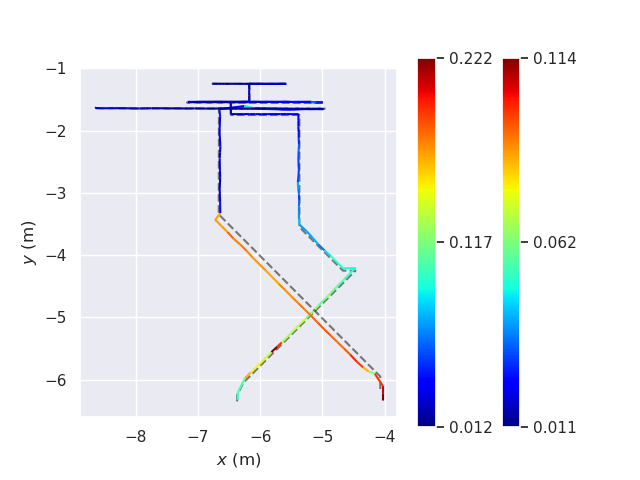

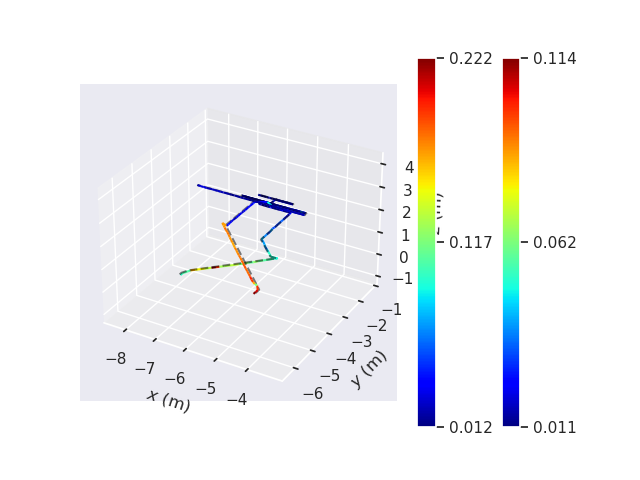

In [21]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    fig = plt.figure()
    ax = plot.prepare_axis(fig, plot_mode)
    
    for agent_id in agent_ids:
        result = main_ape.ape(traj_refs[agent_id], traj_ests[agent_id], est_name=est_name,
                              pose_relation=pose_relation, align=align, correct_scale=correct_scale)
        results.append(result)

        if show_plot:
            plot.traj(ax, plot_mode, traj_refs[agent_id], style="--", alpha=0.5)
            plot.traj_colormap(
                ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
                min_map=result.stats["min"], max_map=result.stats["max"])
    count += 1
    
    
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})

In [9]:
import evo.main_rpe as main_rpe

count = 0
results = []

def callback_rpe(pose_relation, delta, delta_unit, all_pairs, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="RPE Test #{}".format(count)
    result = main_rpe.rpe(traj1_ref, traj1_est, est_name=est_name,
                          pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, 
                          all_pairs=all_pairs, align=align, correct_scale=correct_scale, 
                          support_loop=True)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj1_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])

_ = ipywidgets.interact_manual(callback_rpe, pose_relation=pose_relation_selector, plot_mode=plotmode_selector, 
                               delta=delta_input, delta_unit=delta_unit_selector, 
                               **{c.description: c.value for c in check_boxes_rpe})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…